In [1]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

#load np arrays in pytorch tensors and dataloaders
data = np.load('./data/egamma_norm.npz')

#split into train (90%) /valid (10%) set
seed = 123
X_train, X_valid, y_train, y_valid = train_test_split(data['X_train'], data['y_train'], test_size=0.1, stratify=data['y_train'], random_state=seed)

X_test, y_test = data['X_test'], data['y_test']

train_x, train_y = torch.Tensor(X_train).permute(0, 3, 1, 2), torch.Tensor(y_train).unsqueeze(1)
valid_x, valid_y = torch.Tensor(X_valid).permute(0, 3, 1, 2), torch.Tensor(y_valid).unsqueeze(1)
test_x, test_y = torch.Tensor(X_test).permute(0, 3, 1, 2), torch.Tensor(y_test).unsqueeze(1)

train_set = TensorDataset(train_x, train_y)
valid_set = TensorDataset(valid_x, valid_y)
test_set = TensorDataset(test_x, test_y)

In [2]:
#load tensors into dataloaders
batch_size = 32
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
valid_dl = DataLoader(valid_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#define network structure
class Net(nn.Module):
    def __init__(self, skip_connection=False):
        
        super().__init__()
        
        self.skip_connection = skip_connection
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, padding=1),
            nn.ReLU())
        
        self.convlayer1p1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.maxpool1 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64))
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU())   
        
        self.convlayer2p1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.maxpool2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(128))   
        
        self.convlayer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU())   
        
        self.convlayer3p1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.maxpool3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(128))  
        
        self.convlayer4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1),
            nn.ReLU())
            
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        
        x_res = self.convlayer1(x)
        x = self.convlayer1p1(x_res)
        if self.skip_connection: x = x+x_res
        x = self.maxpool1(x)
        
        x_res = self.convlayer2(x)
        x = self.convlayer2p1(x_res)
        if self.skip_connection: x = x+x_res
        x = self.maxpool2(x)
                
        x_res = self.convlayer3(x)
        x = self.convlayer3p1(x_res)
        if self.skip_connection: x = x+x_res
        x = self.maxpool3(x)
        
        x = self.convlayer4(x)
        
        x = x.mean([2,3])
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.fc(x)
        
        return torch.sigmoid(x)

In [4]:
from torchinfo import summary

#Check network struct
summary(Net(), (batch_size, 2, 32, 32), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          1,216
│    └─ReLU: 2-2                         [32, 64, 32, 32]          --
├─Conv2d: 1-2                            [32, 64, 32, 32]          36,928
├─Sequential: 1-3                        [32, 64, 16, 16]          --
│    └─MaxPool2d: 2-3                    [32, 64, 16, 16]          --
│    └─ReLU: 2-4                         [32, 64, 16, 16]          --
│    └─BatchNorm2d: 2-5                  [32, 64, 16, 16]          128
├─Sequential: 1-4                        [32, 128, 16, 16]         --
│    └─Conv2d: 2-6                       [32, 128, 16, 16]         73,856
│    └─ReLU: 2-7                         [32, 128, 16, 16]         --
├─Conv2d: 1-5                            [32, 128, 16, 16]         147,58

In [5]:
#find gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from sklearn.metrics import roc_auc_score
from torch.utils.tensorboard import SummaryWriter

#Logging with tensorboard

layout = {
    "Task1": {
        "loss": ["Multiline", ["Loss/Train", "Loss/Test", "Loss/Valid"]],
        "accuracy": ["Multiline", ["Accuracy/Train", "Accuracy/Test", "Accuracy/Valid"]],
        "auc": ["Multiline", ["AUC/Train", "AUC/Test", "AUC/Valid"]],
    },
}

writer = SummaryWriter(log_dir='logs/runs')
writer.add_custom_scalars(layout)

#testing function
def evaluate_metrics(model, dl, epoch, label="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    outputs, targets = [], []
    with torch.no_grad():
        for data, target in dl:
            
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            #compute sum of loss
            test_loss += F.binary_cross_entropy(output, target, reduction='sum').item()
            
            #save predictions for computation of auc
            outputs += output.flatten().tolist()
            targets += target.flatten().tolist()
            
            #compute # of correct prediction
            pred = (output>0.5)

            correct += (pred==target.to(torch.bool)).sum()
        
        #compute average loss, accuracy and auc
        test_loss /= len(dl.dataset)
        test_accuracy = correct / len(dl.dataset)
        auc = roc_auc_score(targets, outputs)
        
    writer.add_scalar(f'Loss/{label}', test_loss, epoch)
    writer.add_scalar(f'Accuracy/{label}', test_accuracy, epoch)
    writer.add_scalar(f'AUC/{label}', auc, epoch)

    print('\n{} set Epoch: {} Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), AUC :{}\n'.format(
        label,
        epoch,
        test_loss, 
        correct, len(dl.dataset),
        100. * test_accuracy, auc))
    return auc

In [7]:
log_interval = 1000
import random
import torchvision.transforms as transforms

#training function
def runTrain(model, dl, epoch, optimizer):
    model.train()
    counter = 0
    for batch_idx, (data, target) in enumerate(dl):
        sys.stdout.flush()

        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
        
        #add data aug with random flips/rotations
        h_flip_rand = torch.nonzero(torch.randint(0, 2, (data.shape[0], )))
        data[h_flip_rand] = data[h_flip_rand].flip(2+1)

        v_flip_rand = torch.nonzero(torch.randint(0, 2, (data.shape[0], )))
        data[v_flip_rand] = data[v_flip_rand].flip(3+1)
        
#         rotate_rand = torch.nonzero(torch.randint(0, 2, (data.shape[0], )))
#         for to_rotate in rotate_rand:
#             data[to_rotate] = transforms.functional.rotate(data[to_rotate],random.random()*360, fill=(-0.00115032/0.02362085, 0.0002377/0.06677763))        

        output = model(data)

        loss = F.binary_cross_entropy(output, target)

        loss.backward()
        optimizer.step()
        
        pred = (output>0.5)
        correct = (pred==target.to(torch.bool)).sum()
        
        train_accuracy = correct / len(data)
        
        counter += len(data)
        
        if batch_idx % log_interval == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}, Batch Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, counter, len(dl.dataset),
            100. * batch_idx / len(dl), loss.item(), 
            correct, len(data), 100. * train_accuracy))

In [ ]:
n_epochs = 100

import sys
sys.stdout = open("logs/my_log_pytorch.txt", "a")

model = Net().to(device)

#define optimizer and scheduler
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=2, verbose=True)

#list to apply early stopping if valid auc stopped improving
auc_cur, best_auc = -999, -999
stopping_epochs, stopping_epochs_counter = 5, 0

#run train and test
for epoch in range(1, n_epochs + 1):
    runTrain(model, train_dl, epoch, optimizer)

    #check testing set metrics
    evaluate_metrics(model, test_dl, epoch)
    
    #check training set metrics
    evaluate_metrics(model, train_dl, epoch, 'Train')
        
    #check valid set metrics
    auc_cur = evaluate_metrics(model, valid_dl, epoch, 'Valid')
    
    #reduce lr
    scheduler.step(auc_cur)
    
    torch.save(model, "models/task1_model_pytorch.pt")
    
    #do early stopping
    if auc_cur > best_auc:
        best_auc = auc_cur
        stopping_epochs_counter = 0
    else:
        stopping_epochs_counter += 1
        
    if stopping_epochs_counter >= stopping_epochs: 
        print('----------early breaking----------')
        break
    

In [1]:
!cat logs/my_log_pytorch.txt

Train Epoch: 1 [32/358164 (0%)]	Batch Loss: 0.660098, Batch Accuracy: 22/32 (69%)

Train Epoch: 1 [32032/358164 (9%)]	Batch Loss: 0.640820, Batch Accuracy: 18/32 (56%)

Train Epoch: 1 [64032/358164 (18%)]	Batch Loss: 0.664560, Batch Accuracy: 20/32 (62%)

Train Epoch: 1 [96032/358164 (27%)]	Batch Loss: 0.513574, Batch Accuracy: 24/32 (75%)

Train Epoch: 1 [128032/358164 (36%)]	Batch Loss: 0.603347, Batch Accuracy: 21/32 (66%)

Train Epoch: 1 [160032/358164 (45%)]	Batch Loss: 0.619950, Batch Accuracy: 21/32 (66%)

Train Epoch: 1 [192032/358164 (54%)]	Batch Loss: 0.830589, Batch Accuracy: 13/32 (41%)

Train Epoch: 1 [224032/358164 (63%)]	Batch Loss: 0.670503, Batch Accuracy: 21/32 (66%)

Train Epoch: 1 [256032/358164 (71%)]	Batch Loss: 0.650753, Batch Accuracy: 20/32 (62%)

Train Epoch: 1 [288032/358164 (80%)]	Batch Loss: 0.648964, Batch Accuracy: 23/32 (72%)

Train Epoch: 1 [320032/358164 (89%)]	Batch Loss: 0.703436, Batch Accuracy: 19/32 (59%)

Train Epoch: 1 [352032/358164 (98%)]	Batc

AUC
Number of Epochs 32: Testing 0.8123, Training 0.8258, Valid 0.8138
Accuracy
Number of Epochs 32: Testing 0.7405, Training 0.7522, Valid 0.7430
Loss
Number of Epochs 32: Testing 0.5296, Training 0.5130, Valid 0.5275
Best Test AUC achieved at Epoch 32: 0.8123
Test AUC achieved at the last Epoch: 0.8123


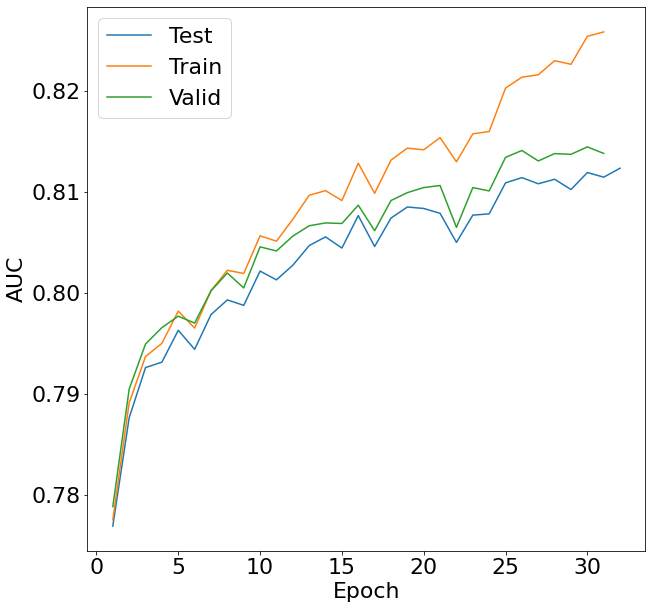

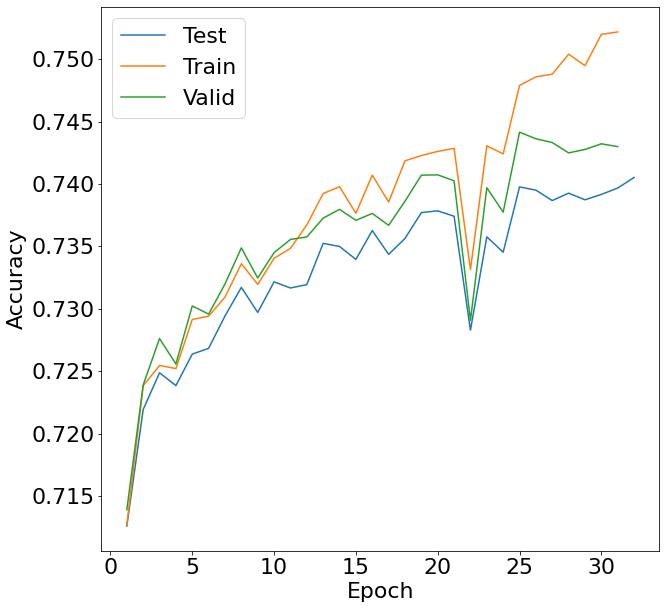

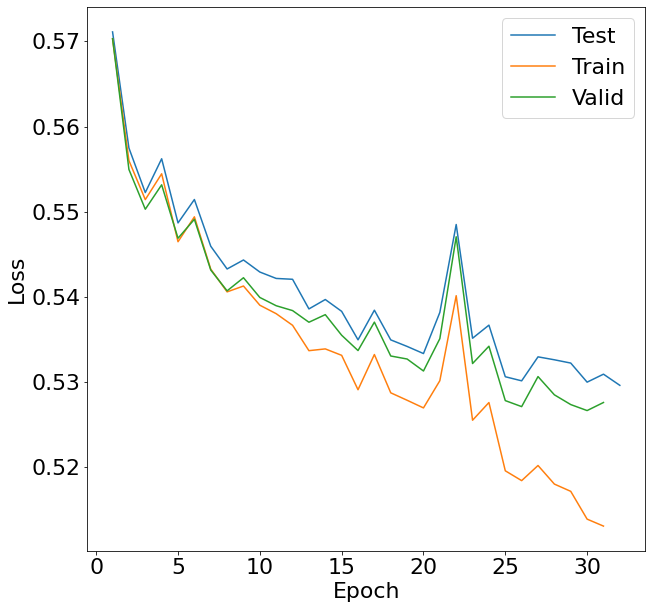

In [5]:
from tensorboard.backend.event_processing import event_accumulator
import tensorboard as tb
import matplotlib.pyplot as plt
import numpy as np
import glob, os

#load training metrics
list_of_runs = glob.glob('logs/runs/*')
latest_run = max(list_of_runs, key=os.path.getctime)

event_acc = event_accumulator.EventAccumulator(latest_run, size_guidance={event_accumulator.SCALARS: 0})
event_acc.Reload()

metrics = {}
for scalar in event_acc.Tags()["scalars"]:
    w_times, step, val = zip(*event_acc.Scalars(scalar))
    metrics[scalar] = [step, val]

#Plot training/valid/testing metrics
for metric in set([_.split('/')[0] for _ in metrics.keys()]):
    plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 22})
    plt.plot(metrics[metric+'/Test'][0], metrics[metric+'/Test'][1], label='Test')
    plt.plot(metrics[metric+'/Train'][0], metrics[metric+'/Train'][1], label='Train')
    plt.plot(metrics[metric+'/Valid'][0], metrics[metric+'/Valid'][1], label='Valid')
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    print(metric)
    print('Number of Epochs {}: Testing {:.4f}, Training {:.4f}, Valid {:.4f}'.format(len(metrics[metric+'/Test'][0]), metrics[metric+'/Test'][1][-1], metrics[metric+'/Train'][1][-1], metrics[metric+'/Valid'][1][-1]))
    
print('Best Test AUC achieved at Epoch {}: {:.4f}'.format(np.argmax(metrics['AUC/Test'][1])+1, max(metrics['AUC/Test'][1])))
print('Test AUC achieved at the last Epoch: {:.4f}'.format(metrics['AUC/Test'][1][-1]))